In [1]:
import kbench
from xaosim.shmlib import shm
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

chip = kbench.Chip(6)

✅ BMC lib found. Running in control mode.


/tmp/ipykernel_86869/3895357141.py:7: DeprecationWarning: Chip is deprecated, use Arch instead
  chip = kbench.Chip(6)


In [2]:
channel = 17
current = 300 # mA
tension = 10 # V

CUR = current * 65535 / 300
VOLT = tension * 65535 / 40

In [3]:
kbench.xpow.send_command(f"CH:{channel}-{channel}:CUR:{int(CUR)}")

'CH:17-17:CUR:65535\t>> Channel 17-17 set to 65535'

In [4]:
kbench.xpow.send_command(f"CH:{channel}-{channel}:VOLT:{int(VOLT)}")

'CH:17-17:VOLT:16383\t>> Channel 17-17 set to 16383'

In [5]:
kbench.xpow.send_command(f"CH:{channel}:VAL?")

'CH:17:VAL?\t>> Channel 17 = 9.988V, 13.743mA'

In [6]:
# px window around the output
crop_size = 10
# px coordinates of the output spots
crop_centers = np.array([(320, 310),
                        (353, 310),
                        (385, 310),
                        (417, 310)])

# Power ramp
ramp = np.linspace(0, 1.2, 101) # [W]

# Controlled equipments
shifter = kbench.PhaseShifter(17)
cam = kbench.Cred3()
arch = kbench.Arch(6)

Cred3 camera initialized with dark subtraction


[ 0.     6.816  9.647 11.819 13.605 15.2   16.601 17.921 19.103 20.257
 21.357 22.373 23.335 24.27  25.149 26.002 26.854 27.651 28.448 29.218
 29.96  30.702 31.417 32.131 32.818 33.478 34.165 34.825 35.457 36.117
 36.749] [ 0.     4.943  6.991  8.562  9.89  11.055 12.11  13.082 13.985 14.831
 15.635 16.397 17.127 17.826 18.5   19.148 19.777 20.385 20.973 21.552
 22.111 22.658 23.191 23.712 24.217 24.721 25.211 25.691 26.162 26.625
 27.078] [0.         0.03369149 0.06743253 0.1009631  0.13449903 0.168036
 0.20103811 0.23437084 0.26753305 0.30045182 0.33341493 0.36642971
 0.39963521 0.43158395 0.4657745  0.49840329 0.53162554 0.56369329
 0.5966968  0.62967712 0.66306467 0.69621888 0.72924925 0.76182601
 0.7949176  0.82760964 0.86065312 0.89527818 0.92762603 0.96239677
 0.99446848]


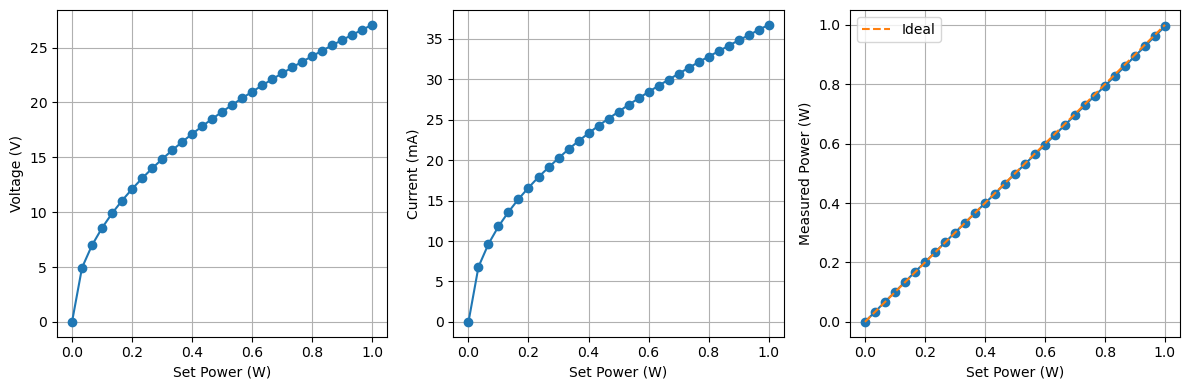

In [7]:
# Test the new set_power() method with auto-calibration
shifter = kbench.PhaseShifter(17)

power_range = np.linspace(0, 1, 31)

real_voltage = np.empty_like(power_range)
real_current = np.empty_like(power_range)
real_power = np.empty_like(power_range)

for i, p in enumerate(power_range):
    shifter.set_power(p)
    real_voltage[i] = shifter.get_voltage()
    real_current[i] = shifter.get_current()
    real_power[i] = shifter.get_power()

print(real_current, real_voltage, real_power)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(power_range, real_voltage, '-o')
axs[0].set_ylabel("Voltage (V)")
axs[0].set_xlabel("Set Power (W)")
axs[0].grid()

axs[1].plot(power_range, real_current, '-o')
axs[1].set_ylabel("Current (mA)")
axs[1].set_xlabel("Set Power (W)")
axs[1].grid()

axs[2].plot(power_range, real_power, '-o')
axs[2].plot(power_range, power_range, '--', label='Ideal')
axs[2].set_ylabel("Measured Power (W)")
axs[2].set_xlabel("Set Power (W)")
axs[2].legend()
axs[2].grid()
plt.tight_layout()
plt.show()


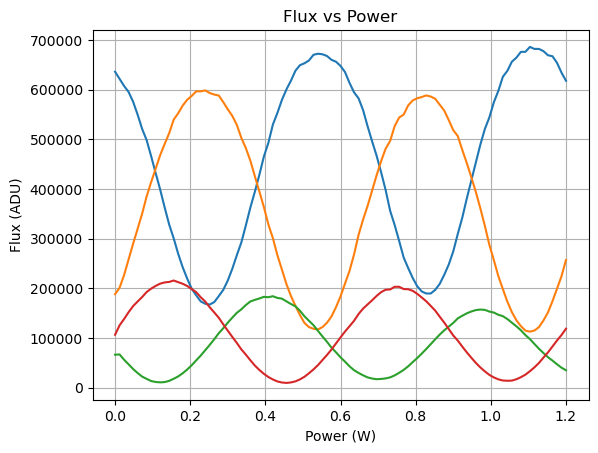

In [8]:
# Data acquisition
flux = []
for power in ramp:
    shifter.set_power(power)
    flux.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))


plt.figure()
plt.plot(ramp, flux)
plt.xlabel("Power (W)")
plt.ylabel("Flux (ADU)")
plt.title("Flux vs Power")
plt.grid()
plt.show()

sleep(3)
shifter.turn_off()

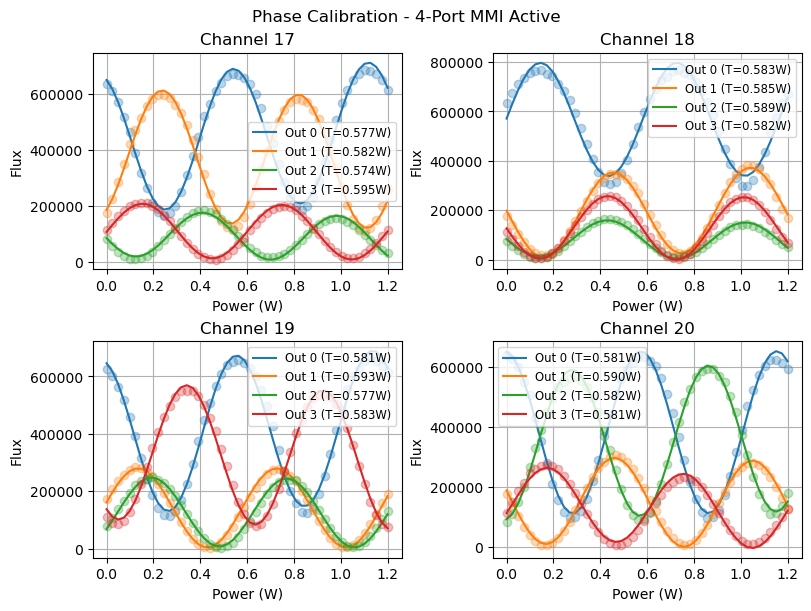

In [9]:
arch.calibrate_phase(samples=50, cred3_object=cam, crop_centers=crop_centers, crop_sizes=crop_size, plot=True)

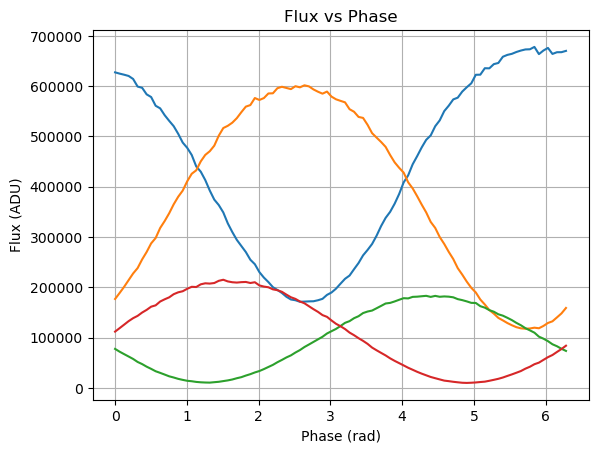

In [ ]:
# Power ramp
ramp = np.linspace(0, 2*np.pi, 101) # [W]

# Data acquisition
flux = []
for shift in ramp:
    shifter.set_phase(shift)
    flux.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))


plt.figure()
plt.plot(ramp, flux)
plt.xlabel("Phase (rad)")
plt.ylabel("Flux (ADU)")
plt.title("Flux vs Phase")
plt.grid()
plt.show()